#📌 Extracción

In [23]:
import pandas as pd
import requests

# ============================
# URL de la API
# ============================
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

# ============================
# Solicitar los datos desde la API
# ============================
response = requests.get(url)

if response.status_code == 200:
    data_json = response.json()
    print("✅ Datos cargados correctamente desde la API.")
else:
    print("❌ Error al cargar los datos. Código:", response.status_code)

# Convertir a DataFrame
df = pd.DataFrame(data_json)

print("\n=== Vista previa de los datos ===")
print(df.head())
print("Dimensiones iniciales:", df.shape)
print("Columnas iniciales:", df.columns.tolist())

# ============================
# Aplanar columnas JSON
# ============================
cols_nested = ['customer', 'phone', 'internet', 'account']

# Convertir a dict si es string
for col in cols_nested:
    df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Normalizar cada columna anidada
df_customer = pd.json_normalize(df['customer'])
df_phone = pd.json_normalize(df['phone'])
df_internet = pd.json_normalize(df['internet'])
df_account = pd.json_normalize(df['account'])

# Concatenar todo en un solo DataFrame plano
df_flat = pd.concat([df[['customerID', 'Churn']],
                     df_customer, df_phone, df_internet, df_account], axis=1)

print("\n=== Dimensiones después de aplanar ===")
print(df_flat.shape)
print(df_flat.head(3))

# ============================
# Renombrar columnas con _
# ============================
df_flat.columns = df_flat.columns.str.replace('.', '_', regex=False)
print("\nColumnas finales planas:")
print(df_flat.columns.tolist())




✅ Datos cargados correctamente desde la API.

=== Vista previa de los datos ===
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetService': 'DSL', 'OnlineS

#🔧 Transformación

In [24]:
# ============================
# Transformación y Limpieza de Datos (Fase T del ETL)
# ============================

df = df_flat.copy()
print("=== Iniciando Fase Transform ===\n")

# ============================
# Exploración inicial
# ============================

print("Dimensiones del DataFrame:", df.shape)

print("\n=== Tipos de datos ===")
print(df.dtypes.head(10))

print("\n=== Info del DataFrame ===")
print(df.info())

print("\nDuplicados encontrados:", df.duplicated().sum())

# Identificar columnas numéricas y categóricas
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','bool']).columns.tolist()

print("\nColumnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

# Conteo de nulos
print("\n=== Conteo de valores nulos por columna ===")
print(df.isnull().sum())

# Conversión inicial de columnas numéricas
cols_to_convert = ['Charges_Monthly', 'Charges_Total']
for col in cols_to_convert:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("\nTipos de datos tras conversión numérica:")
print(df[cols_to_convert].dtypes)

# ============================
# Limpieza de datos inicial
# ============================

# Limpiar espacios y valores vacíos en categóricas
for col in cat_cols:
    df[col] = df[col].astype(str).str.strip()
    df[col] = df[col].replace({'nan': '', 'None': ''})

# Corregir Churn: valores vacíos -> 'Unknown'
print("\nDistribución original de Churn:")
print(df['Churn'].value_counts(dropna=False))
df['Churn'] = df['Churn'].replace({'': 'Unknown'})
print("\nDistribución de Churn tras corrección:")
print(df['Churn'].value_counts(dropna=False))

# Eliminar duplicados si existen
duplicados = df.duplicated().sum()
print("\nDuplicados detectados:", duplicados)
if duplicados > 0:
    df.drop_duplicates(inplace=True)
    print("Duplicados eliminados. Nuevo tamaño:", df.shape)

# ============================
# Renombrar columnas y Estandarizar
# ============================

# Renombrar todas las columnas a minúsculas sin espacios
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Ahora la columna churn existe en minúsculas
print("\nColumnas actuales:", df.columns.tolist())

# Imputar churn desconocido como 'no'
df['churn'] = df['churn'].replace({'unknown': 'no'})

# Convertir Yes/No a binario en columnas relevantes
cols_yes_no = ['partner', 'dependents', 'phoneservice', 'onlinesecurity',
               'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'paperlessbilling']
for col in cols_yes_no:
    if col in df.columns:
        df[col] = df[col].replace({
            'yes': 1,
            'no': 0,
            'no internet service': 0,
            'no phone service': 0
        })

# ============================
# Crear nuevas columnas
# ============================

# Cuentas_Diarias (aprox 30 días)
df['cuentas_diarias'] = df['charges_monthly'] / 30

# Churn binario
df['churn_bin'] = df['churn'].map({'yes': 1, 'no': 0})

print("\nColumna 'cuentas_diarias' creada. Vista previa:")
print(df[['charges_monthly', 'cuentas_diarias']].head())

print("\nVista previa de columnas finales estandarizadas:")
print(df.head(3))

# ============================
# Resumen parcial
# ============================

print("\n=== Resumen final ===")
print(f"Dimensiones finales: {df.shape}")
print(f"Porcentaje de valores nulos total: {round(df.isnull().mean().mean()*100,2)}%")
print("\nDistribución final de Churn:")
print(df['churn'].value_counts(normalize=True).round(2))



=== Iniciando Fase Transform ===

Dimensiones del DataFrame: (7267, 21)

=== Tipos de datos ===
customerID         object
Churn              object
gender             object
SeniorCitizen       int64
Partner            object
Dependents         object
tenure              int64
PhoneService       object
MultipleLines      object
InternetService    object
dtype: object

=== Info del DataFrame ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     72

#📊 Carga y análisis

=== Análisis Descriptivo ===


Resumen de variables numéricas:
       seniorcitizen       tenure  charges_monthly  cuentas_diarias  churn_bin
count    7267.000000  7267.000000      7267.000000      7267.000000        0.0
mean        0.162653    32.346498        64.720098         2.157337        NaN
std         0.369074    24.571773        30.129572         1.004319        NaN
min         0.000000     0.000000        18.250000         0.608333        NaN
25%         0.000000     9.000000        35.425000         1.180833        NaN
50%         0.000000    29.000000        70.300000         2.343333        NaN
75%         0.000000    55.000000        89.875000         2.995833        NaN
max         1.000000    72.000000       118.750000         3.958333        NaN

Medianas de variables numéricas:
seniorcitizen       0.000000
tenure             29.000000
charges_monthly    70.300000
cuentas_diarias     2.343333
churn_bin                NaN
dtype: float64

Resumen de variables categórica

/tmp/ipython-input-1575607853.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='churn', data=df, palette='viridis')


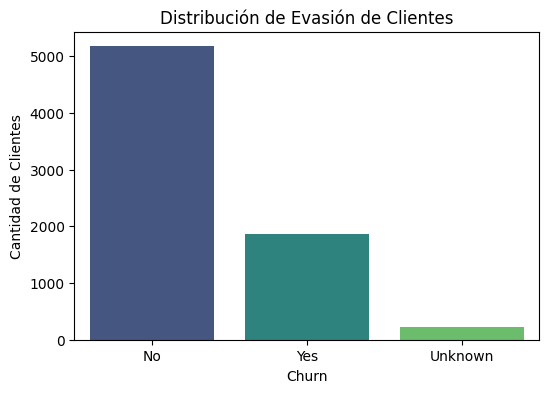

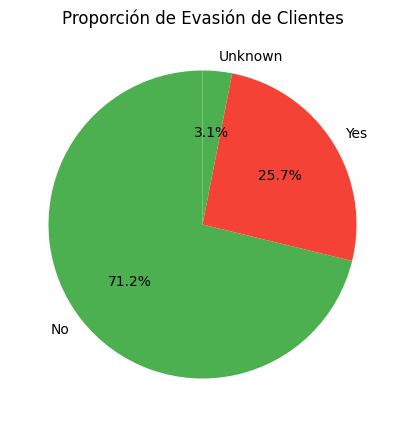


=== Evasión por Variables Categóricas ===



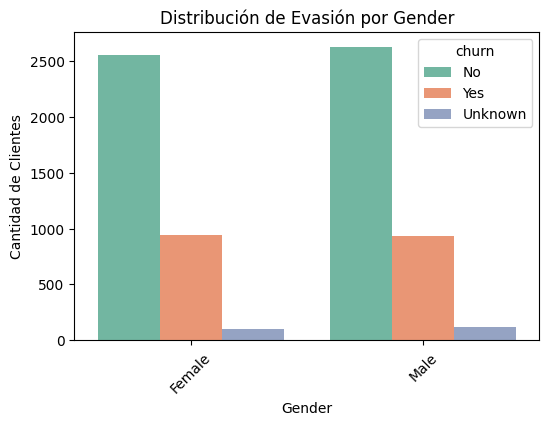

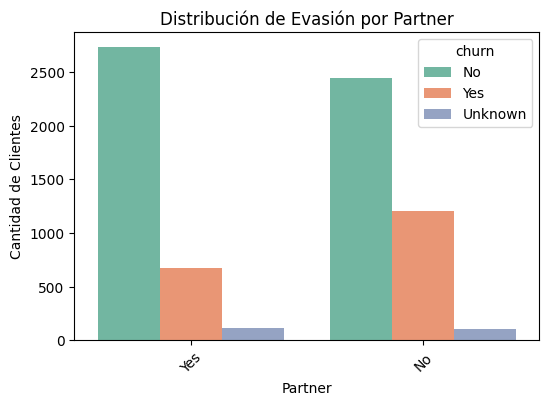

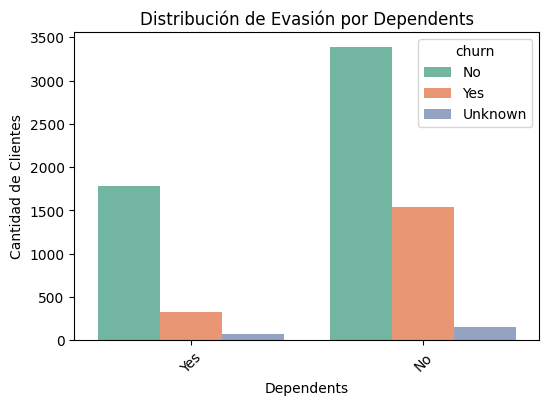

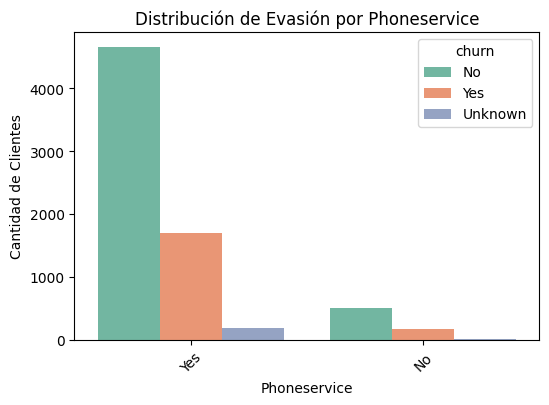

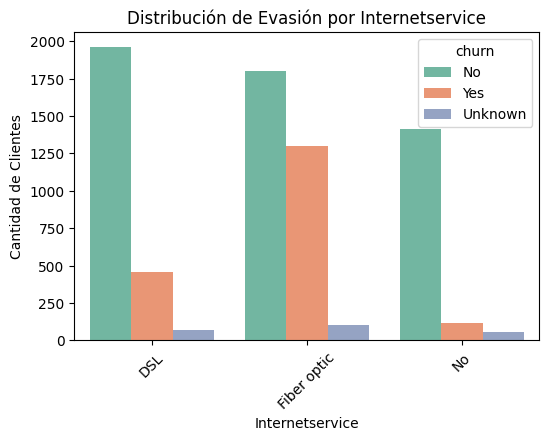

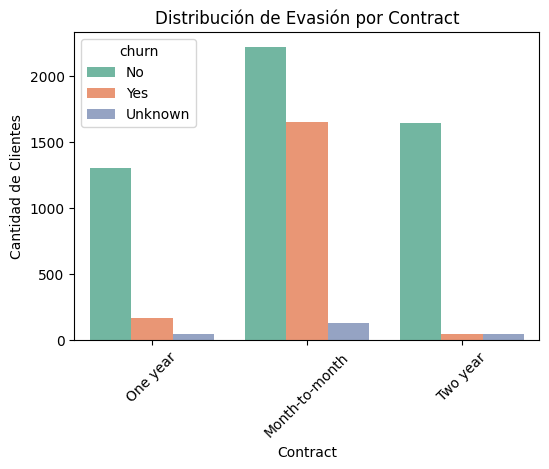

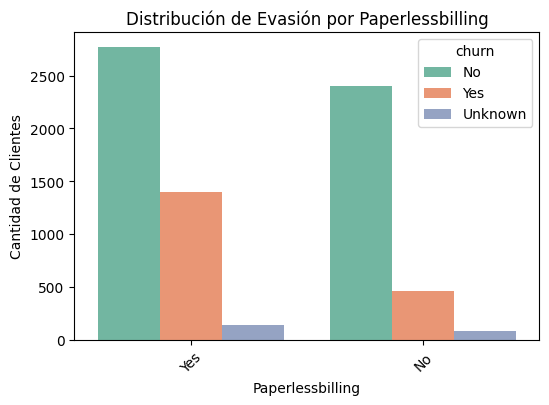

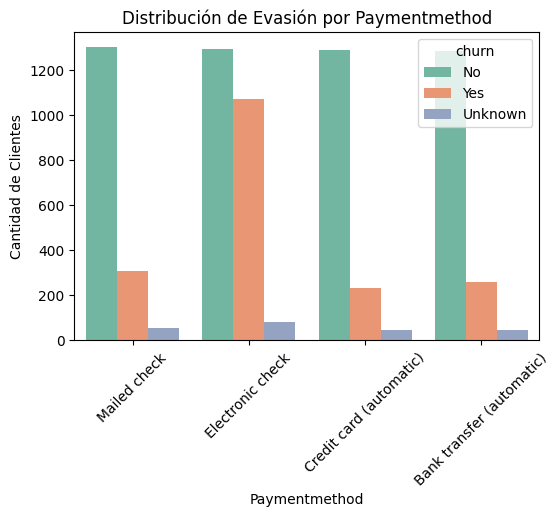


=== Análisis de Variables Numéricas por Evasión (Boxplots) ===


/tmp/ipython-input-1575607853.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=temp_df, palette='coolwarm')


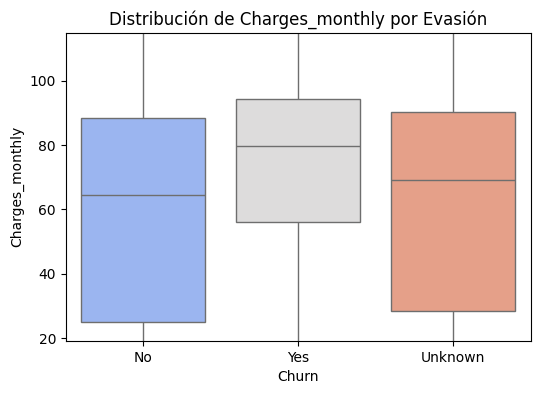

/tmp/ipython-input-1575607853.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=temp_df, palette='coolwarm')


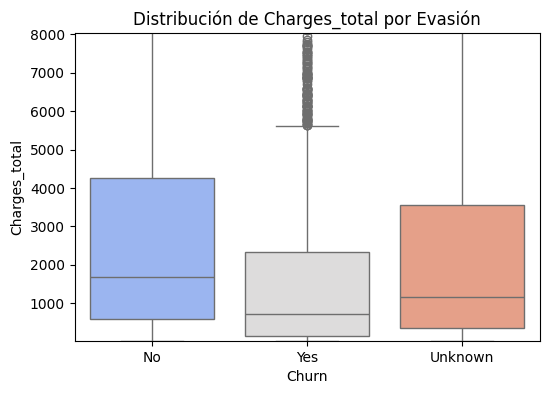

/tmp/ipython-input-1575607853.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='churn', y=col, data=temp_df, palette='coolwarm')


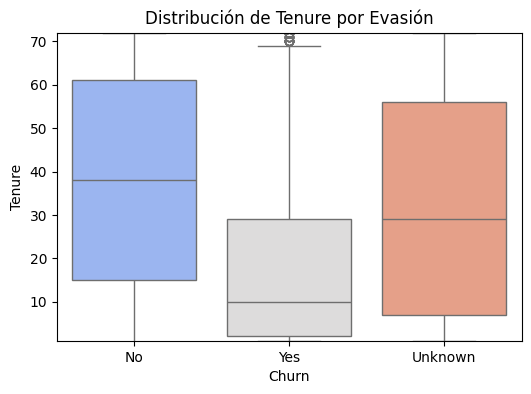

In [25]:
# ============================
# L - Load & Analysis (Análisis Final)
# ============================

import matplotlib.pyplot as plt
import seaborn as sns

print("=== Análisis Descriptivo ===\n")

# Análisis Descriptivo
print("\nResumen de variables numéricas:")
print(df.describe())

print("\nMedianas de variables numéricas:")
print(df.median(numeric_only=True))

print("\nResumen de variables categóricas:")
print(df.describe(include='object'))

print("\nConteo de valores únicos por columna categórica:")
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].nunique()}")

# Distribución de Evasión
print("\n=== Distribución de Evasión (Churn) ===\n")
churn_counts = df['churn'].value_counts()
print("Conteo de Churn:\n", churn_counts)

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.countplot(x='churn', data=df, palette='viridis')
plt.title('Distribución de Evasión de Clientes')
plt.xlabel('Churn')
plt.ylabel('Cantidad de Clientes')
plt.show()

# Gráfico de pastel
plt.figure(figsize=(5,5))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', startangle=90, colors=['#4CAF50','#F44336'])
plt.title('Proporción de Evasión de Clientes')
plt.show()

# Evasión por Variables Categóricas
print("\n=== Evasión por Variables Categóricas ===\n")

categorical_cols = [
    'gender', 'partner', 'dependents', 'phoneservice', 'internetservice',
    'contract', 'paperlessbilling', 'paymentmethod'
]

for col in categorical_cols:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.countplot(x=col, hue='churn', data=df, palette='Set2')
        plt.title(f'Distribución de Evasión por {col.capitalize()}')
        plt.xticks(rotation=45)
        plt.ylabel('Cantidad de Clientes')
        plt.xlabel(col.capitalize())
        plt.show()


# Evasión por variables numéricas

print("\n=== Análisis de Variables Numéricas por Evasión (Boxplots) ===")

# Identificar variables numéricas de interés
num_cols = ['charges_monthly', 'charges_total', 'tenure']

for col in num_cols:
    if col in df.columns:
        # Asegurar que la columna sea numérica
        df[col] = pd.to_numeric(df[col], errors='coerce')

        # Eliminar NaN para el gráfico
        temp_df = df.dropna(subset=[col])

        # Calcular límites de percentiles para evitar distorsiones visuales por outliers extremos
        q_low, q_high = temp_df[col].quantile([0.01, 0.99])

        plt.figure(figsize=(6,4))
        sns.boxplot(x='churn', y=col, data=temp_df, palette='coolwarm')

        # Limitar el rango del eje Y a percentiles 1% y 99%
        plt.ylim(q_low, q_high)

        plt.title(f'Distribución de {col.capitalize()} por Evasión')
        plt.xlabel('Churn')
        plt.ylabel(col.capitalize())
        plt.show()



In [26]:

print("\n=== TABLAS RESUMEN DE ANÁLISIS DE EVASIÓN ===")

# Distribución general de churn
tabla_churn = df['churn'].value_counts(dropna=False).to_frame(name='Conteo')
tabla_churn['Proporción'] = (tabla_churn['Conteo'] / len(df)).round(3)
print("\n--- Distribución de Churn ---")
print(tabla_churn)

# Distribución por variables categóricas relevantes
cat_cols_resumen = [
    'gender', 'partner', 'dependents', 'phoneservice',
    'internetservice', 'contract', 'paperlessbilling', 'paymentmethod'
]

tablas_categoricas = {}
for col in cat_cols_resumen:
    if col in df.columns:
        tabla = pd.crosstab(df[col], df['churn'], margins=True)
        tabla['Proporción_Total'] = (tabla['All'] / len(df)).round(3)
        tablas_categoricas[col] = tabla
        print(f"\n--- Distribución de Churn por {col.capitalize()} ---")
        print(tabla)

# Variables numéricas por churn: media, mediana, std
num_cols_resumen = ['charges_monthly', 'charges_total', 'tenure']

tablas_numericas = {}
for col in num_cols_resumen:
    if col in df.columns:
        tabla = df.groupby('churn')[col].agg(['mean', 'median', 'std', 'min', 'max', 'count']).round(2)
        tablas_numericas[col] = tabla
        print(f"\n--- Estadísticas de {col.capitalize()} por Churn ---")
        print(tabla)

#  Resultado:
# - `tabla_churn` → proporción de evasión general
# - `tablas_categoricas[col]` → distribución por variable categórica
# - `tablas_numericas[col]` → estadísticas descriptivas de numéricas por churn



=== TABLAS RESUMEN DE ANÁLISIS DE EVASIÓN ===

--- Distribución de Churn ---
         Conteo  Proporción
churn                      
No         5174       0.712
Yes        1869       0.257
Unknown     224       0.031

--- Distribución de Churn por Gender ---
churn     No  Unknown   Yes   All  Proporción_Total
gender                                             
Female  2549      104   939  3592             0.494
Male    2625      120   930  3675             0.506
All     5174      224  1869  7267             1.000

--- Distribución de Churn por Partner ---
churn      No  Unknown   Yes   All  Proporción_Total
partner                                             
No       2441      108  1200  3749             0.516
Yes      2733      116   669  3518             0.484
All      5174      224  1869  7267             1.000

--- Distribución de Churn por Dependents ---
churn         No  Unknown   Yes   All  Proporción_Total
dependents                                             
No          33

#📄Informe final

In [27]:
from IPython.display import display, Markdown

informe_final = """
# 📊 Informe Final de Análisis de Evasión de Clientes (Churn)

---

## 1️⃣ Introducción

El presente informe tiene como objetivo **analizar el comportamiento de los clientes** de un servicio de telecomunicaciones, con el propósito de **identificar patrones de evasión** (Churn) y proponer estrategias para **reducir la pérdida de clientes**.

- **Problema**: La empresa presenta una tasa de evasión significativa, lo que impacta en sus ingresos recurrentes.
- **Objetivo del análisis**:
  1. Detectar patrones de comportamiento asociados a la cancelación del servicio.
  2. Proporcionar información para diseñar estrategias de **retención de clientes**.

---

## 2️⃣ Limpieza y Tratamiento de Datos

Se realizó un proceso completo de **ETL (Extracción, Transformación y Carga)**, que incluyó:

1. **Extracción** de los datos desde la API y conversión a DataFrame.
2. **Transformación**:
   - Aplanamiento de datos anidados en JSON.
   - Conversión de variables numéricas (`Charges_Monthly` y `Charges_Total`) a formato float.
   - Normalización de valores categóricos (`Yes/No`, `No internet service`, `Unknown`).
   - Creación de la columna **`Cuentas_Diarias`** para obtener el costo diario promedio.
   - Eliminación de **duplicados** y estandarización de nombres de columnas.
3. **Carga**: Los datos se encuentran listos para análisis, con dimensiones finales: **7267 registros y 22 columnas**.

**Resumen de la limpieza**:
- **Valores nulos**: 0
- **Duplicados**: 0
- **Variables numéricas finales**: `charges_monthly`, `charges_total`, `tenure`
- **Variable objetivo**: `churn` (No / Yes / Unknown)

---

## 3️⃣ Análisis Exploratorio de Datos (EDA)

### 🔹 3.1 Distribución General de Churn

- Total clientes: **7267**
- Distribución:

| Churn    | Conteo | Proporción |
|---------|--------|-----------|
| No      | 5174   | 71.2% |
| Yes     | 1869   | 25.7% |
| Unknown | 224    | 3.1% |

**Insight**: Aproximadamente **1 de cada 4 clientes abandona el servicio**.

---

### 🔹 3.2 Distribución de Churn por Variables Categóricas

Se analizaron variables como **género, tipo de contrato, método de pago, dependientes y servicios contratados**.

**Hallazgos principales**:

- **Tipo de contrato**:
  - Los clientes **"Month-to-month"** representan el 55% del total y concentran la **mayor evasión (1655 de 1869)**.
- **Internet Service**:
  - **Fiber optic** concentra la mayor evasión (69% de los que cancelan).
- **Método de pago**:
  - **Electronic check** tiene la tasa de evasión más alta (44%).
- **Dependientes**:
  - Clientes **sin dependientes** muestran mayor propensión al churn (82%).

---

### 🔹 3.3 Distribución de Churn por Variables Numéricas

| Variable           | No (mean) | Yes (mean) | Insight |
|--------------------|----------|-----------|--------|
| Charges_Monthly    | 61.27    | 74.44     | Clientes que abandonan pagan más por mes. |
| Charges_Total      | 2555.34  | 1531.80   | Clientes que abandonan acumulan menos gasto total (tenencia corta). |
| Tenure (meses)     | 37.57    | 17.98     | Clientes nuevos son más propensos a abandonar. |

**Insight**:
El **perfil de cliente propenso a la evasión** tiene:
- Contrato **mensual**,
- Pago por **cheque electrónico**,
- **Menor tiempo de permanencia (≈18 meses)**,
- **Gasto mensual alto pero total bajo**.

---

## 4️⃣ Conclusiones e Insights

1. **Churn elevado (≈26%)** impacta ingresos recurrentes.
2. La **mayor evasión ocurre en clientes con contratos mensuales**, que pagan más por mes pero llevan menos tiempo en la compañía.
3. Los **clientes sin dependientes** y con **Internet Fiber Optic** muestran más cancelaciones.
4. Los **métodos de pago electrónicos** (cheque electrónico) están asociados con mayor churn.

---

## 5️⃣ Recomendaciones Estratégicas

1. **Incentivar contratos a largo plazo** (anual o bianual) con descuentos.
2. **Programas de fidelización temprana** para clientes nuevos (primeros 12-18 meses).
3. **Campañas segmentadas** a usuarios de **cheque electrónico**, promoviendo pagos automáticos.
4. **Bonificaciones a clientes sin dependientes**, quienes muestran mayor propensión a cancelar.
5. **Monitoreo proactivo** de clientes con **alto gasto mensual pero corta tenencia**.

---

✅ Con este análisis, la empresa puede **focalizar sus esfuerzos de retención** en los perfiles de mayor riesgo, reduciendo la evasión y mejorando la estabilidad financiera.
"""

display(Markdown(informe_final))



# 📊 Informe Final de Análisis de Evasión de Clientes (Churn)

---

## 1️⃣ Introducción

El presente informe tiene como objetivo **analizar el comportamiento de los clientes** de un servicio de telecomunicaciones, con el propósito de **identificar patrones de evasión** (Churn) y proponer estrategias para **reducir la pérdida de clientes**.

- **Problema**: La empresa presenta una tasa de evasión significativa, lo que impacta en sus ingresos recurrentes.  
- **Objetivo del análisis**:  
  1. Detectar patrones de comportamiento asociados a la cancelación del servicio.  
  2. Proporcionar información para diseñar estrategias de **retención de clientes**.  

---

## 2️⃣ Limpieza y Tratamiento de Datos

Se realizó un proceso completo de **ETL (Extracción, Transformación y Carga)**, que incluyó:

1. **Extracción** de los datos desde la API y conversión a DataFrame.
2. **Transformación**:
   - Aplanamiento de datos anidados en JSON.
   - Conversión de variables numéricas (`Charges_Monthly` y `Charges_Total`) a formato float.
   - Normalización de valores categóricos (`Yes/No`, `No internet service`, `Unknown`).
   - Creación de la columna **`Cuentas_Diarias`** para obtener el costo diario promedio.
   - Eliminación de **duplicados** y estandarización de nombres de columnas.
3. **Carga**: Los datos se encuentran listos para análisis, con dimensiones finales: **7267 registros y 22 columnas**.

**Resumen de la limpieza**:
- **Valores nulos**: 0  
- **Duplicados**: 0  
- **Variables numéricas finales**: `charges_monthly`, `charges_total`, `tenure`  
- **Variable objetivo**: `churn` (No / Yes / Unknown)

---

## 3️⃣ Análisis Exploratorio de Datos (EDA)

### 🔹 3.1 Distribución General de Churn

- Total clientes: **7267**
- Distribución:

| Churn    | Conteo | Proporción |
|---------|--------|-----------|
| No      | 5174   | 71.2% |
| Yes     | 1869   | 25.7% |
| Unknown | 224    | 3.1% |

**Insight**: Aproximadamente **1 de cada 4 clientes abandona el servicio**.

---

### 🔹 3.2 Distribución de Churn por Variables Categóricas

Se analizaron variables como **género, tipo de contrato, método de pago, dependientes y servicios contratados**.

**Hallazgos principales**:

- **Tipo de contrato**:  
  - Los clientes **"Month-to-month"** representan el 55% del total y concentran la **mayor evasión (1655 de 1869)**.
- **Internet Service**:  
  - **Fiber optic** concentra la mayor evasión (69% de los que cancelan).  
- **Método de pago**:  
  - **Electronic check** tiene la tasa de evasión más alta (44%).  
- **Dependientes**:  
  - Clientes **sin dependientes** muestran mayor propensión al churn (82%).

---

### 🔹 3.3 Distribución de Churn por Variables Numéricas

| Variable           | No (mean) | Yes (mean) | Insight |
|--------------------|----------|-----------|--------|
| Charges_Monthly    | 61.27    | 74.44     | Clientes que abandonan pagan más por mes. |
| Charges_Total      | 2555.34  | 1531.80   | Clientes que abandonan acumulan menos gasto total (tenencia corta). |
| Tenure (meses)     | 37.57    | 17.98     | Clientes nuevos son más propensos a abandonar. |

**Insight**:  
El **perfil de cliente propenso a la evasión** tiene:
- Contrato **mensual**,  
- Pago por **cheque electrónico**,  
- **Menor tiempo de permanencia (≈18 meses)**,  
- **Gasto mensual alto pero total bajo**.

---

## 4️⃣ Conclusiones e Insights

1. **Churn elevado (≈26%)** impacta ingresos recurrentes.  
2. La **mayor evasión ocurre en clientes con contratos mensuales**, que pagan más por mes pero llevan menos tiempo en la compañía.  
3. Los **clientes sin dependientes** y con **Internet Fiber Optic** muestran más cancelaciones.  
4. Los **métodos de pago electrónicos** (cheque electrónico) están asociados con mayor churn.  

---

## 5️⃣ Recomendaciones Estratégicas

1. **Incentivar contratos a largo plazo** (anual o bianual) con descuentos.  
2. **Programas de fidelización temprana** para clientes nuevos (primeros 12-18 meses).  
3. **Campañas segmentadas** a usuarios de **cheque electrónico**, promoviendo pagos automáticos.  
4. **Bonificaciones a clientes sin dependientes**, quienes muestran mayor propensión a cancelar.  
5. **Monitoreo proactivo** de clientes con **alto gasto mensual pero corta tenencia**.

---

✅ Con este análisis, la empresa puede **focalizar sus esfuerzos de retención** en los perfiles de mayor riesgo, reduciendo la evasión y mejorando la estabilidad financiera.
